# Задача 1

## Проверка метрики "осознанно смотрящий пользователь"

Импортируем все нужные библиотеки

In [2]:
from scipy.stats import chi2_contingency
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

Прочитаем файл **kion_metrics.csv**, полученный в результате sql запросов, и сохраним его в переменной **kion_metrics.csv**

In [3]:
# Импорт данных из файла "kion_metrics.csv"
df = pd.read_csv('data\kion_metrics.csv')
df

,user_id,item_id,content_type,total_dur,watched_pct,consciousness_rating,user_consciousness_rating
0,0,7102,film,169,3.0,1.0,0
1,0,14359,film,130,2.0,1.0,0
2,0,15297,series,459,0.0,1.0,0
3,2,3541,film,4320,83.0,3.0,1
4,2,4475,film,7029,100.0,4.0,1
...,...,...,...,...,...,...,...
499995,1097527,512,film,4606,81.0,3.0,1
499996,1097530,11237,film,5150,94.0,4.0,1
499997,1097534,9996,series,198033,100.0,4.0,1
499998,1097547,5732,film,8043,100.0,4.0,1


Выведем среднюю продолжительность и процент просмотра для каждого типа контента для каждой категории метрики осознаности пользователя

In [4]:
# Группировка по user_consciousness_rating и user_consciousness_rating и вывод средних total_dur и watched_pct
df.groupby(['user_consciousness_rating', 'content_type'], as_index = False).agg({'total_dur' : 'mean', 'watched_pct' : 'mean'})

,user_consciousness_rating,content_type,total_dur,watched_pct
0,0,film,738.740030,13.462147
1,0,series,7790.189335,9.535298
2,1,film,8801.559015,92.663958
3,1,series,48082.360346,82.559771


Как видно, у осознанно смотрящих пользователей у фильмов средний процент просмотра – 92%, у сериалов – 82%, а у неосознанно смотрящих пользователей общая средняя продолжительность просмотра фильмов – 12,3 минуты, сериалов – 2,17 часа, что говорит об адекватности метрики. Однако проверим ее на статистическую значимость.

Т.к метрика **user_consciousness_rating** принимает 2 значения 0 и 1, используем тест на независимость двух выборок. А данном случае проведем **хи-квадрат тест** для переменных метрики осозноннасти и процента просмотра контента. Проведем его отдельно для каждого типа котента.  

Для этого выдвенем гипотезы при уровене значимости **95%**:
- Нулевая гипотеза (H0): Средний процент просмотра контента (watched_pct) не различается между пользователями с user_consciousness_rating равным 0 и 1.
- Альтернативная гипотеза (H1): Средний процент просмотра контента (watched_pct) различается между пользователями с user_consciousness_rating равным 0 и 1.

**Для фильмов**

Сначала посмотрим, сколько строк всего в df для фильмов по группировке по метрике 

In [5]:
# Группировка df по user_consciousness_rating
df.query('content_type == "film"').groupby('user_consciousness_rating').agg({'user_id':'count'})

,user_id
user_consciousness_rating,
0,197711
1,179775


Так как данных достаточно, выберем две случайные выборки по 50000 строк для каждого из 2х вариантов метрики

In [6]:
# Вывод 50000 случайных строк из df, где content_type == "film" и user_consciousness_rating == 1
film_metric_true_sample_data = df.query('content_type == "film" & user_consciousness_rating == 1').sample(n = 50000, random_state=42)
# Вывод 50000 случайных строк из df, где content_type == "film" и user_consciousness_rating == 0
film_metric_false_sample_data = df.query('content_type == "film" & user_consciousness_rating == 0').sample(n = 50000, random_state=42)

Обьеденим две выборки в одну общую

In [7]:
# Объединение film_metric_true_sample_data и film_metric_false_sample_data в датафрейм
film_sample = pd.concat([film_metric_false_sample_data, film_metric_true_sample_data], ignore_index=True)
# Группировка film_sample по user_consciousness_rating
film_sample.groupby('user_consciousness_rating').agg({'user_id':'count'})

,user_id
user_consciousness_rating,
0,50000
1,50000


Проведем хи-квадрат тест

In [8]:
# Создание таблицы сопряженности для user_consciousness_rating и total_dur
contingency_table = pd.crosstab(film_sample['user_consciousness_rating'], film_sample['watched_pct'])

# Проведиение хи-квадрат тест
chi2, p, _, _ = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic for total_dur: {chi2}")
print(f"P-value for total_dur: {p}")

Chi-Square Statistic for total_dur: 96753.8172304374
P-value for total_dur: 0.0


Вывод: p-value меньше 0.05, что говорит о статистически значимых различиях между переменными user_consciousness_rating и watched_pct для фильмов.

**Для сериалов**

Сначала посмотрим, сколько строк всего в df для фильмов по группировке по метрике 

In [9]:
# Группировка df по user_consciousness_rating
df.query('content_type == "series"').groupby('user_consciousness_rating').agg({'user_id':'count'})

,user_id
user_consciousness_rating,
0,85272
1,37242


Так как данных достаточно, выберем две случайные выборки по 50000 строк для каждого из 2х вариантов метрики

In [10]:
# Вывод 50000 случайных строк из df, где content_type == "series" и user_consciousness_rating == 1
series_metric_true_sample_data = df.query('content_type == "series" & user_consciousness_rating == 1').sample(n = 30000, random_state=42)
# Вывод 50000 случайных строк из df, где content_type == "series" и user_consciousness_rating == 0
series_metric_false_sample_data = df.query('content_type == "series" & user_consciousness_rating == 0').sample(n = 30000, random_state=42)

Обьеденим две выборки в одну общую

In [11]:
# Объединение series_metric_true_sample_data и series_metric_false_sample_data в датафрейм
series_sample = pd.concat([series_metric_false_sample_data, series_metric_true_sample_data], ignore_index=True)
# Группировка series_sample по user_consciousness_rating
series_sample.groupby('user_consciousness_rating').agg({'user_id':'count'})

,user_id
user_consciousness_rating,
0,30000
1,30000


Проведем хи-квадрат тест

In [12]:
# Создание таблицы сопряженности для user_consciousness_rating и total_dur
contingency_table = pd.crosstab(series_sample['user_consciousness_rating'], series_sample['watched_pct'])

# Проведите хи-квадрат тест
chi2, p, _, _ = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic for total_dur: {chi2}")
print(f"P-value for total_dur: {p}")

Chi-Square Statistic for total_dur: 59028.999067035635
P-value for total_dur: 0.0


Вывод: p-value меньше 0.05, что говорит о статистически значимых различиях между переменными user_consciousness_rating и watched_pct для сериалов.

**Вывод:** P-value близкое к нулю (0.0) как для фильмов, так и для сериалов в хи-квадрат тесте указывает на то, что существует статистически значимая связь между переменными user_consciousness_rating и watched_pct. Это означает, что средние значения процента просмотра контента значимо различаются между пользователями с разными категориями метрики осознанного просмотра. Следовательно, можно сделать вывод, что метрика показывает статистически значимые различия и является эффективной.

# Задача 2

Ответь на вопросы:
1. Какие факторы сильнее всего влияют на падение ключевых продуктовых метрик?
2. Почему так происходит?

Список гипотез о причинах снижения основных продуктовый метрик:
1. Высокая активность конкурентов в рекламной сфере, что приводит к регистрации пользователей в их продукте и использованию бесплатных периодов, и, в результате, уменьшению активности на нашей платформе.
2. Недоступность определенного контента в нашем онлайн кинотеатре из-за истечения срока контракта с дистрибьютором.
3. Отсутствие нашей платформе популярного контента, который доступен на других онлайн-площадках.

Предложенные способы решения:
1. Пересмотреть методы взаимодействия с разными группами пользователей.
2. Предлагать стимулирующие меры, такие как скидки и специальные предложения, для пользователей, угрожающих оттоком.
3. Внедрить программу лояльности как для постоянных, так и для новых пользователей.
4. Создать специализированную поддержку для пользователей, чей ежемесячный оборот на платформе превышает определенную сумму.
5. Разработать специальный интерфейс для пользователей семейных аккаунтов.
6. Привлечь новых пользователей с помощью маркетинговых кампаний.

# Задача 3

Построить сводную статистику (за последний месяц и за последние 3 месяца, доступные в данных) по контенту в виде дашборда с несколькими графиками, которые помогут ответить на следующие вопросы:
1. Какой контент является самым популярным?
2. Какой контент относится к наименее просматриваемому?
3. Какой контент является самым популярным среди пользователей с детьми?

Прочитаем файл **kion_merged.csv**, полученный в результате sql запросов, и сохраним его в переменной **user_actions**

In [13]:
# Чтение файла 'kion_merged.csv' и сохранение данных в переменной 'user_actions'
user_actions = pd.read_csv('data\kion_merged_2.csv', parse_dates= ['last_watch_dt'], error_bad_lines=False)
# Вывод первых 5 строк данных
user_actions.head(5)

C:\Users\Тимофей\AppData\Local\Temp\ipykernel_17032\1788112916.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  user_actions = pd.read_csv('data\kion_merged_2.csv', parse_dates= ['last_watch_dt'], error_bad_lines=False)
b'Skipping line 184747: expected 13 fields, saw 14\n'
b'Skipping line 445375: expected 13 fields, saw 14\n'
b'Skipping line 605770: expected 13 fields, saw 14\n'
b'Skipping line 1034304: expected 13 fields, saw 14\n'
b'Skipping line 1570773: expected 13 fields, saw 14\n'
b'Skipping line 1606229: expected 13 fields, saw 14\n'


,user_id,item_id,last_watch_dt,total_dur,watched_pct,item_id.1,content_type,title,genres,age,income,sex,kids_flg
0,812384,16087,2021-08-21,2013,31.0,16087,film,Убийство в Восточном экспрессе,"драмы, криминал, детективы",age_18_24,income_20_40,Ж,0
1,505969,7107,2021-05-22,103,25.0,7107,series,Девятаев,"драмы, военные, приключения",age_35_44,income_40_60,М,0
2,625217,5592,2021-07-14,1157,25.0,5592,film,На дальних рубежах,драмы,age_18_24,income_20_40,Ж,0
3,462446,12386,2021-06-27,5321,79.0,12386,film,Мой домашний динозавр,"мультфильм, фэнтези, приключения",age_25_34,income_40_60,Ж,0
4,893512,15297,2021-05-22,1338,13.0,15297,series,Клиника счастья,"драмы, мелодрамы",age_45_54,income_90_150,М,0


Проверим данные на пропуски и дупликаты

In [14]:
# Подсчет пропусков
user_actions.isna().sum()

user_id              0
item_id              0
last_watch_dt        0
total_dur            0
watched_pct        411
item_id.1            0
content_type         0
title                0
genres               0
age              36990
income           35736
sex              37115
kids_flg             0
dtype: int64

Как видим, в столбце "watched_pct" есть 411 пропусков, это могут быть как и сбои данных, так и то, что пользователь начал смотреть контент и сразу же вышел, 411 - относительно нашего датасета небольшое число, так что их можно удалить. Также большое количестов пропусков в столбцах "age", "income", "sex", это может быть связано с тем, что пользователи не указали свои данные, но отсутствие этой информации не повлияет на исследуемые задачи


In [52]:
# Удаление пропусков
user_actions = user_actions.dropna(subset = ['watched_pct'])
# Проверка на успешность удаления пропусков
user_actions.isna().sum()

user_id              0
item_id              0
last_watch_dt        0
total_dur            0
watched_pct          0
item_id.1            0
content_type         0
title                0
genres               0
age              36970
income           35718
sex              37096
kids_flg             0
dtype: int64

Проверим данные на дупликаты

In [16]:
# Расчет количества дупликатов
user_actions.duplicated().sum()

0

Как видно, дупликатов в датафрейме нет

Так как нужно проанализировать последний месяц, выберем данные за август (последний месяц в нашем датафрейме)

In [17]:
# Фильтрация данных для последнего месяца
user_actions_last_month = user_actions[(user_actions['last_watch_dt'] >= '2021-08-01') & (user_actions['last_watch_dt'] <= '2021-08-22')]
# Вывод первых 5 строк отфильтрованных данных
user_actions_last_month.head(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct,item_id.1,content_type,title,genres,age,income,sex,kids_flg
0,812384,16087,2021-08-21,2013,31.0,16087,film,Убийство в Восточном экспрессе,"драмы, криминал, детективы",age_18_24,income_20_40,Ж,0
5,205648,3905,2021-08-01,1490,28.0,3905,film,Внеземное эхо,"фантастика, семейное, приключения",age_18_24,income_20_40,Ж,0
15,828388,5434,2021-08-02,7214,100.0,5434,film,История семьи Блум,драмы,age_65_inf,income_40_60,М,0
17,934243,15297,2021-08-07,6527,25.0,15297,series,Клиника счастья,"драмы, мелодрамы",age_45_54,income_20_40,М,0
24,663761,15297,2021-08-19,636,0.0,15297,series,Клиника счастья,"драмы, мелодрамы",age_18_24,income_40_60,Ж,0


Посчитаем отдельно для фильмов и для сериалов 10 самых популярных и непопулярных фильмов/сериалов и жанров для нихкак  для обычных пользователей, так и для пользователей с детьми 

## Для фильмов

Выведем самые популярные фильмы

In [18]:
# Создание поддатафрейма для фильмов
user_actions_last_month_films = user_actions_last_month.query('content_type == "film"')

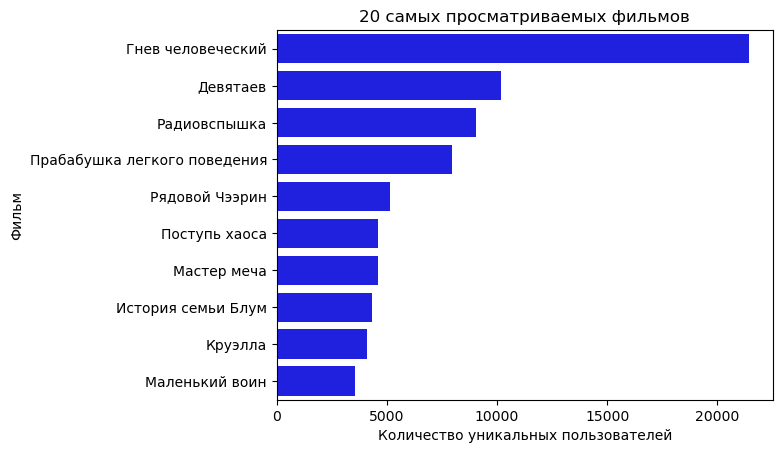

In [19]:
# Группировка фильмов по названию и подсчет уникальных пользователей
most_popular_films = user_actions_last_month_films.query('content_type == "film"').groupby('title').agg({'user_id' : 'nunique'}).reset_index()
# Сортировка фильмов по количеству уникальных пользователей (популярность)
most_popular_films = most_popular_films.sort_values(by='user_id', ascending=False)
# Выбор 10 самых популярных фильмов
most_popular_films_10 = most_popular_films.head(10)

# Создание столбчатой диаграммы для отображения результатов
sns.barplot(x=most_popular_films_10.user_id, y=most_popular_films_10.title, color = 'blue')

# Настройка заголовка и меток осей
plt.title('20 самых просматриваемых фильмов')
plt.xlabel('Количество уникальных пользователей')
plt.ylabel('Фильм')

# Отображаем график
plt.show()

Самые популярные фильмы с для пользователей с детьми

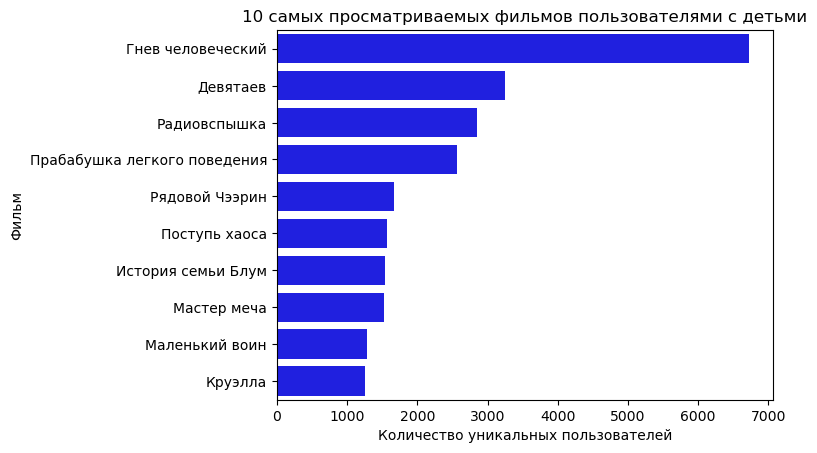

In [20]:
# Создание поддатафрейма для фильмов с детьми
user_actions_last_month_films_with_kids = user_actions_last_month.query('content_type == "film" & kids_flg == 1')

# Группировка фильмов для пользователей с детьми по названию и подсчет уникальных пользователей
most_popular_films_with_kids = user_actions_last_month_films_with_kids.groupby('title').agg({'user_id' : 'nunique'}).reset_index()
# Сортировка фильмов для пользователей с детьми по популярности
most_popular_films_with_kids = most_popular_films_with_kids.sort_values(by='user_id', ascending=False)
# Выбор 10 самых популярных фильмов для пользователей с детьми
most_popular_films_with_kids_10 = most_popular_films_with_kids.head(10)

# Создание столбчатой диаграммы для отображения результатов
sns.barplot(x=most_popular_films_with_kids_10.user_id, y=most_popular_films_with_kids_10.title, color = 'blue')

# Настройка заголовка и меток осей
plt.title('10 самых просматриваемых фильмов пользователями с детьми')
plt.xlabel('Количество уникальных пользователей')
plt.ylabel('Фильм')

# Отображаем график
plt.show()

Как видно, в зависимости от того, есть ли у пользоватедя дети или нет 10 самых популярных фильмов остаются такими же, однако некоторые фильмы меняются местами в рейтинге популярности

Самые непопулярные фильмы

In [21]:
# Выбор 10 наименее популярных фильмов
least_popular_films_10 = most_popular_films.tail(10)
# Отображение наименее популярных фильмов
display(least_popular_films_10)

,title,user_id
3749,Отец мучеников,1
3747,Отель ужасов,1
3743,Отель Зловещих Гейш,1
532,Багровый Пик,1
534,Бажарики 2,1
3735,Отдай свою душу,1
3734,Отвязные приключения в Лондоне,1
3732,Ответный ход,1
3726,Осьминожки,1
6043,…А в душе я танцую,1


In [22]:
# Подсчет количества фильмов с одним просмотром
number_of_films_with_1_view = most_popular_films[most_popular_films['user_id'] == 1].user_id.count()
print(f'Количесвто фильмов с 1 просмотром: {number_of_films_with_1_view}')

Количесвто фильмов с 1 просмотром: 1302


Самые непопулярные фильмы дял пользователей с детьми

In [23]:
# Подсчет наименее популярных фильмов для пользователей с детьми
least_popular_films_with_kids_10 = most_popular_films_with_kids.tail(10)
# Отображение наименее популярных фильмов для пользователей с детьми
display(least_popular_films_with_kids_10)

,title,user_id
1608,Идеальный камуфляж,1
3484,Робин Уильямс: Загляни в мою душу,1
1598,Игры на выживание,1
1599,Игры разума,1
1602,Идеальная мишень,1
3480,Ритуалы народа дани. Западное Папуа,1
1604,Идеальная пара,1
1605,Идеальное оружие,1
3477,Римские свидания,1
4575,Ясновидящая,1


In [24]:
# Подсчет количества фильмов с одним просмотром пользователями с детьми
number_of_films_with_1_view_with_kids = most_popular_films_with_kids[most_popular_films_with_kids['user_id'] == 1].user_id.count()
print(f'Количесвто фильмов с 1 просмотром пользователями с детьми: {number_of_films_with_1_view_with_kids}')

Количесвто фильмов с 1 просмотром пользователями с детьми: 1159


Как видно, как у пользователей с детьми, так и без большое количество фильмов с 1 просмотром: 1306 и 1159 соответственно

Самые популярные жанры фильмов

In [25]:
# Вывод поддатасета для фильмов
user_actions_last_month_films.head(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct,item_id.1,content_type,title,genres,age,income,sex,kids_flg
0,812384,16087,2021-08-21,2013,31.0,16087,film,Убийство в Восточном экспрессе,"драмы, криминал, детективы",age_18_24,income_20_40,Ж,0
5,205648,3905,2021-08-01,1490,28.0,3905,film,Внеземное эхо,"фантастика, семейное, приключения",age_18_24,income_20_40,Ж,0
15,828388,5434,2021-08-02,7214,100.0,5434,film,История семьи Блум,драмы,age_65_inf,income_40_60,М,0
30,619125,4725,2021-08-16,593,10.0,4725,film,Лобановский навсегда,"спорт, биография, документальное",age_65_inf,income_40_60,М,1
34,737823,8980,2021-08-12,968,13.0,8980,film,Звёздные войны: Эпизод 4 — Новая надежда,"боевики, фантастика, фэнтези, приключения",age_18_24,income_40_60,М,0


In [26]:
# Разделение столбца 'genres' на отдельные жанры
user_actions_last_month_films['genres_split'] = user_actions_last_month_films['genres'].str.split(',')
# Вывод первых 5 строк данных после разделения жанров
user_actions_last_month_films.head(5)

C:\Users\Тимофей\AppData\Local\Temp\ipykernel_17032\2748706689.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_actions_last_month_films['genres_split'] = user_actions_last_month_films['genres'].str.split(',')


,user_id,item_id,last_watch_dt,total_dur,watched_pct,item_id.1,content_type,title,genres,age,income,sex,kids_flg,genres_split
0,812384,16087,2021-08-21,2013,31.0,16087,film,Убийство в Восточном экспрессе,"драмы, криминал, детективы",age_18_24,income_20_40,Ж,0,"[драмы, криминал, детективы]"
5,205648,3905,2021-08-01,1490,28.0,3905,film,Внеземное эхо,"фантастика, семейное, приключения",age_18_24,income_20_40,Ж,0,"[фантастика, семейное, приключения]"
15,828388,5434,2021-08-02,7214,100.0,5434,film,История семьи Блум,драмы,age_65_inf,income_40_60,М,0,[драмы]
30,619125,4725,2021-08-16,593,10.0,4725,film,Лобановский навсегда,"спорт, биография, документальное",age_65_inf,income_40_60,М,1,"[спорт, биография, документальное]"
34,737823,8980,2021-08-12,968,13.0,8980,film,Звёздные войны: Эпизод 4 — Новая надежда,"боевики, фантастика, фэнтези, приключения",age_18_24,income_40_60,М,0,"[боевики, фантастика, фэнтези, приключения]"


In [27]:
# Создание дополнительных записей для каждого жанра
user_actions_films_genres_split = user_actions_last_month_films.explode('genres_split')
# Удаление лишних пробелов в названиях жанров
user_actions_films_genres_split['genres_split'] = user_actions_films_genres_split['genres_split'].str.strip()

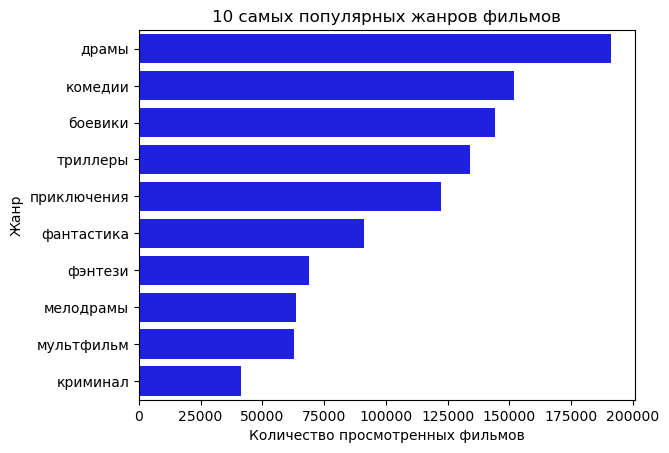

In [28]:
# Подсчет количества просмотренных фильмов для каждого жанра
popular_genres_films_top_10 = user_actions_films_genres_split.genres_split.value_counts().head(10)
# Преобразование результатов в DataFrame
popular_genres_films_top_10 = pd.DataFrame(popular_genres_films_top_10)

# Создание столбчатой диаграммы для отображения результатов
sns.barplot(x = popular_genres_films_top_10.genres_split, y = popular_genres_films_top_10.index, color = 'blue')

# Настройка заголовка и меток осей
plt.title('10 самых популярных жанров фильмов')
plt.xlabel('Количество просмотренных фильмов')
plt.ylabel('Жанр')

# Отображаем график
plt.show()

Самые популярные жанры фильмов для пользователей с детьми

In [29]:
# Анализ популярных жанров фильмов для пользователей с детьми
user_actions_last_month_films_with_kids.head(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct,item_id.1,content_type,title,genres,age,income,sex,kids_flg
30,619125,4725,2021-08-16,593,10.0,4725,film,Лобановский навсегда,"спорт, биография, документальное",age_65_inf,income_40_60,М,1
48,564950,5434,2021-08-09,4677,82.0,5434,film,История семьи Блум,драмы,age_35_44,income_20_40,Ж,1
67,96450,16152,2021-08-13,251,4.0,16152,film,Код апокалипсиса,"боевики, приключения",age_35_44,income_40_60,М,1
80,752666,12228,2021-08-18,156,2.0,12228,film,Волк с Уолл-стрит,"драмы, биография, криминал, комедии",age_45_54,income_20_40,М,1
99,160092,8419,2021-08-02,177,3.0,8419,film,Невероятный Халк,"боевики, фантастика, триллеры",age_35_44,income_20_40,М,1


In [30]:
# Разделение столбца 'genres' на отдельные жанры
user_actions_last_month_films_with_kids['genres_split'] = user_actions_last_month_films_with_kids['genres'].str.split(',')
# Вывод первых 5 строк данных после разделения жанров
user_actions_last_month_films_with_kids.head(5)

C:\Users\Тимофей\AppData\Local\Temp\ipykernel_17032\2154128326.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_actions_last_month_films_with_kids['genres_split'] = user_actions_last_month_films_with_kids['genres'].str.split(',')


,user_id,item_id,last_watch_dt,total_dur,watched_pct,item_id.1,content_type,title,genres,age,income,sex,kids_flg,genres_split
30,619125,4725,2021-08-16,593,10.0,4725,film,Лобановский навсегда,"спорт, биография, документальное",age_65_inf,income_40_60,М,1,"[спорт, биография, документальное]"
48,564950,5434,2021-08-09,4677,82.0,5434,film,История семьи Блум,драмы,age_35_44,income_20_40,Ж,1,[драмы]
67,96450,16152,2021-08-13,251,4.0,16152,film,Код апокалипсиса,"боевики, приключения",age_35_44,income_40_60,М,1,"[боевики, приключения]"
80,752666,12228,2021-08-18,156,2.0,12228,film,Волк с Уолл-стрит,"драмы, биография, криминал, комедии",age_45_54,income_20_40,М,1,"[драмы, биография, криминал, комедии]"
99,160092,8419,2021-08-02,177,3.0,8419,film,Невероятный Халк,"боевики, фантастика, триллеры",age_35_44,income_20_40,М,1,"[боевики, фантастика, триллеры]"


In [31]:
# Создание дополнительных записей для каждого жанра
user_actions_with_kids_flims_genres_split = user_actions_last_month_films_with_kids.explode('genres_split')
# Удаление лишних пробелов в названиях жанров
user_actions_with_kids_flims_genres_split['genres_split'] = user_actions_with_kids_flims_genres_split['genres_split'].str.strip()

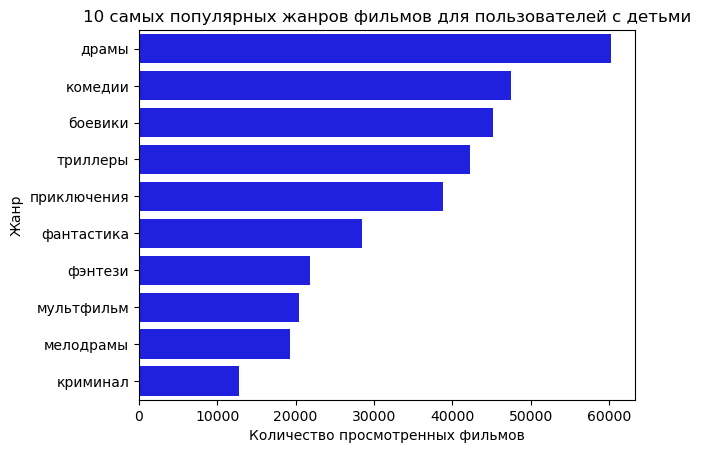

In [32]:
# Подсчет количества просмотренных фильмов для каждого жанра пользователей с детьми
popular_genres_with_kids_films_top_10 = user_actions_with_kids_flims_genres_split.genres_split.value_counts().head(10)
# Преобразование результатов в DataFrame
popular_genres_with_kids_films_top_10 = pd.DataFrame(popular_genres_with_kids_films_top_10)

# Создание столбчатой диаграммы для отображения результатов
sns.barplot(x = popular_genres_with_kids_films_top_10.genres_split, y = popular_genres_with_kids_films_top_10.index, color = 'blue')

# Настройка заголовка и меток осей
plt.title('10 самых популярных жанров фильмов для пользователей с детьми')
plt.xlabel('Количество просмотренных фильмов')
plt.ylabel('Жанр')

# Отображаем график
plt.show()

Как видно, 10 саых популярных жанров не отличаются вне зависимости от того, есть ли у пользователя дети. Т.е наличие детей глобально не влияет на тип предпочитаемого контента пользователями и значит пользователи в меньшей степени используют KION для просмтора детских фильмов и показа детям детского контента. Значит увеличивать лизенции детского контента на сервисе не целесообразно

Самые не популярные жанры

,genres_split
фильмы-спектакли,4
короткий метр,4
музыка,3
единоборства,3
немое кино,3
сериалы,2
красота и здоровье,2
тележурналы,1
артхаус,1
реалити-шоу,1


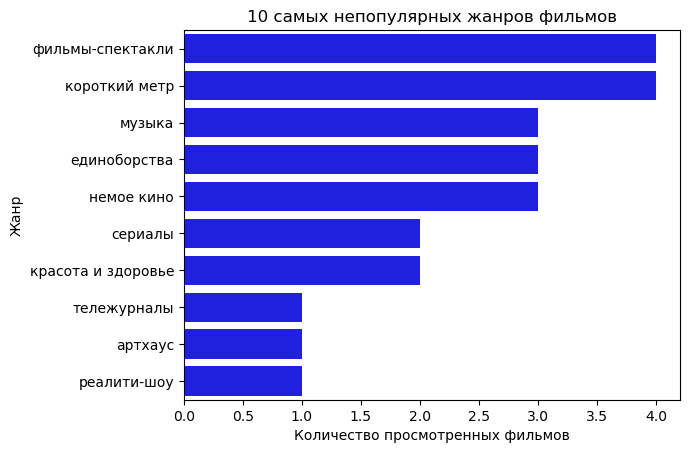

In [33]:
# Анализ наименее популярных жанров фильмов
unpopular_genres__films_top_10 = user_actions_films_genres_split.genres_split.value_counts().tail(10)
# Преобразование результатов в DataFrame
unpopular_genres__films_top_10 = pd.DataFrame(unpopular_genres__films_top_10)

# Создание столбчатой диаграммы для отображения результатов
sns.barplot(x = unpopular_genres__films_top_10.genres_split, y = unpopular_genres__films_top_10.index, color = 'blue')

# Настройка заголовка и меток осей
plt.title('10 самых непопулярных жанров фильмов')
plt.xlabel('Количество просмотренных фильмов')
plt.ylabel('Жанр')


display(unpopular_genres__films_top_10)

# Отображаем график
plt.show()

Самы непопулярные жанры для пользователей с детьми

,genres_split
хочу всё знать,3
единоборства,2
фильмы-спектакли,2
юмор,1
анимация,1
детские песни,1
мировая классика,1
красота и здоровье,1
артхаус,1
музыка,1


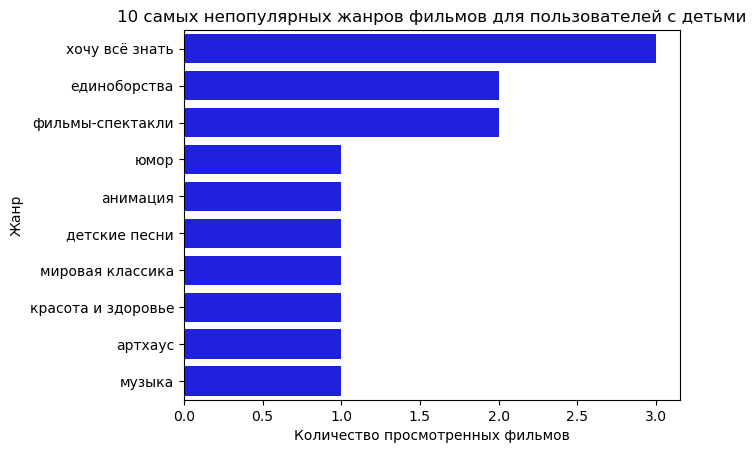

In [34]:
# Анализ наименее популярных жанров фильмов для пользователей с детьми
unpopular_genres_with_kids_films_top_10 = user_actions_with_kids_flims_genres_split.genres_split.value_counts().tail(10)
# Преобразование результатов в DataFrame
unpopular_genres_with_kids_films_top_10 = pd.DataFrame(unpopular_genres_with_kids_films_top_10)

sns.barplot(x = unpopular_genres_with_kids_films_top_10.genres_split, y = unpopular_genres_with_kids_films_top_10.index, color = 'blue')

# Настройка заголовка и меток осей
plt.title('10 самых непопулярных жанров фильмов для пользователей с детьми')
plt.xlabel('Количество просмотренных фильмов')
plt.ylabel('Жанр')

# Создание столбчатой диаграммы для отображения результатов
display(unpopular_genres_with_kids_films_top_10)

# Отображаем график
plt.show()

Видно, что самые непопулярные жанры - довольно специфические жанры по типу "артхаус" и "единоборства", также есть жанр "юмор", который можно отнести к более устоявшемуся названию "комедия". 

## Для сериалов

Рассмотрим самые популярные сериалы

In [35]:
# Анализ данных для сериалов
user_actions_last_month_series = user_actions_last_month.query('content_type == "series"')

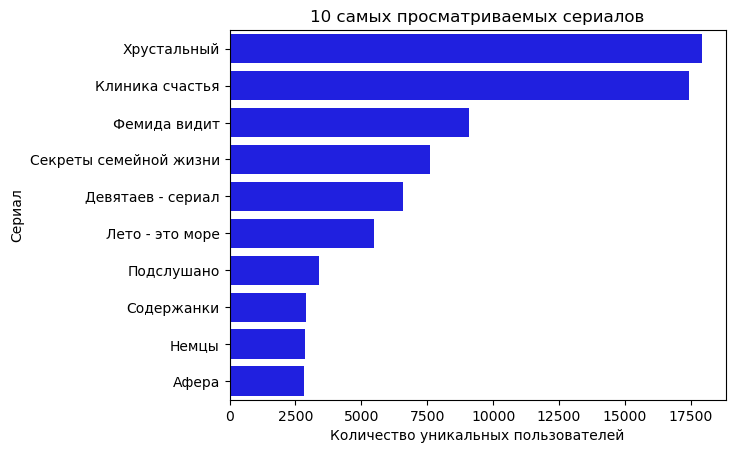

In [36]:
# Группировка сериалов по названию и подсчет уникальных пользователей
most_popular_series = user_actions_last_month_series.groupby('title').agg({'user_id' : 'nunique'}).reset_index()
# Сортировка сериалов по популярности
most_popular_series = most_popular_series.sort_values(by='user_id', ascending=False)
# Выбор 10 самых популярных сериалов
most_popular_series_10 = most_popular_series.head(10)

# Создание столбчатой диаграммы для отображения результатов
sns.barplot(x=most_popular_series_10.user_id, y=most_popular_series_10.title, color = 'blue')

# Настройка заголовка и меток осей
plt.title('10 самых просматриваемых сериалов')
plt.xlabel('Количество уникальных пользователей')
plt.ylabel('Сериал')

# Отображаем график
plt.show()

Самые популярные сериалы с для пользователей с детьми

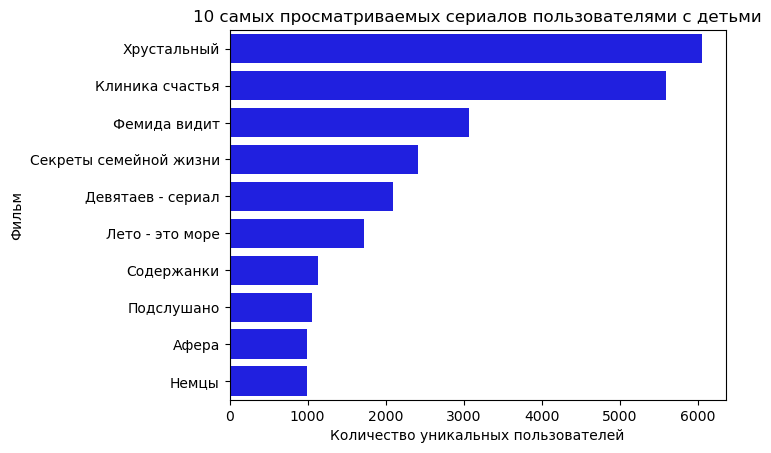

In [37]:
# Создание поддатафрейма для сериалов с детьми
user_actions_last_month_series_with_kids = user_actions_last_month.query('content_type == "series" & kids_flg == 1')

# Группировка сериалов для пользователей с детьми по названию и подсчет уникальных пользователей
most_popular_series_with_kids = user_actions_last_month_series_with_kids.groupby('title').agg({'user_id' : 'nunique'}).reset_index()
# Сортировка сериалов для пользователей с детьми по популярности
most_popular_series_with_kids= most_popular_series_with_kids.sort_values(by='user_id', ascending=False)
# Выбор 10 самых популярных сериалов для пользователей с детьми
most_popular_series_with_kids_10 = most_popular_series_with_kids.head(10)

# Создание столбчатой диаграммы для отображения результатов
sns.barplot(x=most_popular_series_with_kids_10.user_id, y=most_popular_series_with_kids_10.title, color = 'blue')

# Настройка заголовка и меток осей
plt.title('10 самых просматриваемых сериалов пользователями с детьми')
plt.xlabel('Количество уникальных пользователей')
plt.ylabel('Фильм')

# Отображаем график
plt.show()

Как видно, для обычных пользователей и для пользователей с детьми 10 самых популярных сериалов не отличаются

Самые непопулярные сериалы

In [38]:
# Выбор 10 наименее популярных сериалов
least_popular_series_10 = most_popular_series.tail(10)
# Отображение наименее популярных сериалов
display(least_popular_series_10)

,title,user_id
868,Наемник Куорри,1
869,Наживка для Ангела,1
870,Найджел Слейтер. Ближневосточная кухня,1
871,Найди отличия,1
883,Не отпускай мою руку,1
888,Небесные ласточки,1
890,Небоа,1
900,Немецкий алфавит для детей,1
902,Немой,1
1636,Ящик Пандоры,1


In [39]:
# Подсчет количества сериалов с одним просмотром
number_of_series_with_1_view = most_popular_series[most_popular_series['user_id'] == 1].user_id.count()
print(f'Количесвто сериалов с 1 просмотром: {number_of_series_with_1_view}')

Количесвто сериалов с 1 просмотром: 392


Самые непопулярные сериалы для пользователей с детьми

In [40]:
# Анализ наименее популярных сериалов для пользователей с детьми
least_popular_series_with_kids_10 = most_popular_series_with_kids.tail(10)
# Отображение наименее популярных сериалов для пользователей с детьми
display(least_popular_series_with_kids_10)

,title,user_id
934,Слепые пятна,1
491,Легенда Феррари,1
464,Кровавый след,1
471,Крюк,1
475,"Кто, если не я?",1
476,Кукушка,1
926,Сказки Серого Волка,1
924,Синичкин календарь,1
488,Ласточкино гнездо,1
1171,Ящик Пандоры,1


In [41]:
# Подсчет количества сериалов с одним просмотром пользователями с детьми
number_of_series_with_1_view_with_kids = most_popular_series_with_kids[most_popular_series_with_kids['user_id'] == 1].user_id.count()
print(f'Количесвто сериалов с 1 просмотром пользователями с детьми: {number_of_series_with_1_view_with_kids}')

Количесвто сериалов с 1 просмотром пользователями с детьми: 299


Как видно, как у пользователей с детьми, так и без большое количество сериалов с 1 просмотром: 299 и 392 соответственно

Самые популярные жанры сериалов

In [42]:
# Анализ популярных жанров сериалов
user_actions_last_month_series.head(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct,item_id.1,content_type,title,genres,age,income,sex,kids_flg
17,934243,15297,2021-08-07,6527,25.0,15297,series,Клиника счастья,"драмы, мелодрамы",age_45_54,income_20_40,М,0
24,663761,15297,2021-08-19,636,0.0,15297,series,Клиника счастья,"драмы, мелодрамы",age_18_24,income_40_60,Ж,0
29,109887,15297,2021-08-09,27109,88.0,15297,series,Клиника счастья,"драмы, мелодрамы",age_35_44,income_20_40,М,0
35,26919,15297,2021-08-16,10,0.0,15297,series,Клиника счастья,"драмы, мелодрамы",age_55_64,income_20_40,Ж,0
50,256651,16228,2021-08-06,5077,5.0,16228,series,Содержанки,триллеры,age_45_54,income_20_40,Ж,0


In [43]:
# Разделение столбца 'genres' на отдельные жанры
user_actions_last_month_series['genres_split'] = user_actions_last_month_series['genres'].str.split(',')
# Вывод первых 5 строк данных после разделения жанров
user_actions_last_month_series.head(5)

C:\Users\Тимофей\AppData\Local\Temp\ipykernel_17032\4050889191.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_actions_last_month_series['genres_split'] = user_actions_last_month_series['genres'].str.split(',')


,user_id,item_id,last_watch_dt,total_dur,watched_pct,item_id.1,content_type,title,genres,age,income,sex,kids_flg,genres_split
17,934243,15297,2021-08-07,6527,25.0,15297,series,Клиника счастья,"драмы, мелодрамы",age_45_54,income_20_40,М,0,"[драмы, мелодрамы]"
24,663761,15297,2021-08-19,636,0.0,15297,series,Клиника счастья,"драмы, мелодрамы",age_18_24,income_40_60,Ж,0,"[драмы, мелодрамы]"
29,109887,15297,2021-08-09,27109,88.0,15297,series,Клиника счастья,"драмы, мелодрамы",age_35_44,income_20_40,М,0,"[драмы, мелодрамы]"
35,26919,15297,2021-08-16,10,0.0,15297,series,Клиника счастья,"драмы, мелодрамы",age_55_64,income_20_40,Ж,0,"[драмы, мелодрамы]"
50,256651,16228,2021-08-06,5077,5.0,16228,series,Содержанки,триллеры,age_45_54,income_20_40,Ж,0,[триллеры]


In [44]:
# Создание дополнительных записей для каждого жанра
user_actions_genres_split_series = user_actions_last_month_series.explode('genres_split')
# Удаление лишних пробелов в названиях жанров
user_actions_genres_split_series['genres_split'] = user_actions_genres_split_series['genres_split'].str.strip()

,genres_split
драмы,69553
детективы,45746
комедии,38274
триллеры,36217
мелодрамы,36114
приключения,16223
мультсериалы,11382
криминал,10557
военные,9182
фантастика,5618


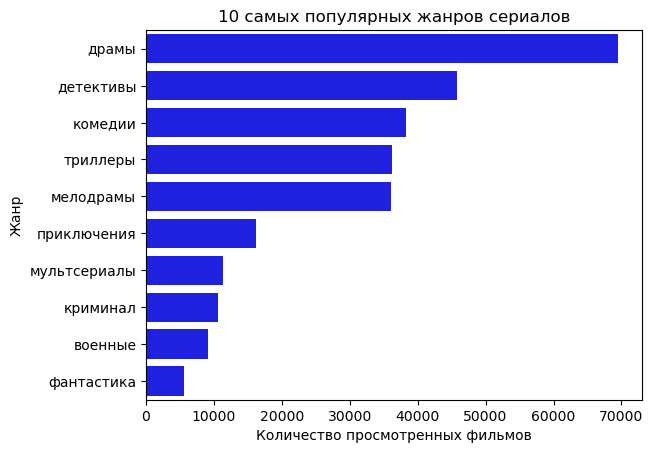

In [45]:
# Подсчет количества просмотренных сериалов для каждого жанра
popular_genres_series_top_10 = user_actions_genres_split_series.genres_split.value_counts().head(10)
# Преобразование результатов в DataFrame
popular_genres_series_top_10 = pd.DataFrame(popular_genres_series_top_10)

# Создание столбчатой диаграммы для отображения результатов
sns.barplot(x = popular_genres_series_top_10.genres_split, y = popular_genres_series_top_10.index, color = 'blue')

# Настройка заголовка и меток осей
plt.title('10 самых популярных жанров сериалов')
plt.xlabel('Количество просмотренных фильмов')
plt.ylabel('Жанр')


display(popular_genres_series_top_10)

# Отображаем график
plt.show()

Самые популярные жанры сериалов для пользователей с детьми

In [46]:
# Анализ популярных жанров сериалов для пользователей с детьми
user_actions_last_month_series_with_kids.head(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct,item_id.1,content_type,title,genres,age,income,sex,kids_flg
62,682924,15297,2021-08-13,26164,75.0,15297,series,Клиника счастья,"драмы, мелодрамы",age_35_44,income_20_40,М,1
88,840013,15297,2021-08-01,473,0.0,15297,series,Клиника счастья,"драмы, мелодрамы",age_45_54,income_20_40,Ж,1
140,948742,15297,2021-08-04,19719,100.0,15297,series,Клиника счастья,"драмы, мелодрамы",age_35_44,income_20_40,Ж,1
155,292182,7476,2021-08-11,1678,0.0,7476,series,Анатомия страсти,"драмы, мелодрамы",age_25_34,income_60_90,Ж,1
230,243397,16228,2021-08-02,12548,15.0,16228,series,Содержанки,триллеры,age_25_34,income_20_40,Ж,1


In [47]:
# Разделение столбца 'genres' на отдельные жанры
user_actions_last_month_series_with_kids['genres_split'] = user_actions_last_month_series_with_kids['genres'].str.split(',')
# Вывод первых 5 строк данных после разделения жанров
user_actions_last_month_series_with_kids.head(5)

C:\Users\Тимофей\AppData\Local\Temp\ipykernel_17032\1021937023.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_actions_last_month_series_with_kids['genres_split'] = user_actions_last_month_series_with_kids['genres'].str.split(',')


,user_id,item_id,last_watch_dt,total_dur,watched_pct,item_id.1,content_type,title,genres,age,income,sex,kids_flg,genres_split
62,682924,15297,2021-08-13,26164,75.0,15297,series,Клиника счастья,"драмы, мелодрамы",age_35_44,income_20_40,М,1,"[драмы, мелодрамы]"
88,840013,15297,2021-08-01,473,0.0,15297,series,Клиника счастья,"драмы, мелодрамы",age_45_54,income_20_40,Ж,1,"[драмы, мелодрамы]"
140,948742,15297,2021-08-04,19719,100.0,15297,series,Клиника счастья,"драмы, мелодрамы",age_35_44,income_20_40,Ж,1,"[драмы, мелодрамы]"
155,292182,7476,2021-08-11,1678,0.0,7476,series,Анатомия страсти,"драмы, мелодрамы",age_25_34,income_60_90,Ж,1,"[драмы, мелодрамы]"
230,243397,16228,2021-08-02,12548,15.0,16228,series,Содержанки,триллеры,age_25_34,income_20_40,Ж,1,[триллеры]


In [48]:
# Создание дополнительных записей для каждого жанра
user_actions_with_kids_series_genres_split = user_actions_last_month_series_with_kids.explode('genres_split')
# Удаление лишних пробелов в названиях жанров
user_actions_with_kids_series_genres_split['genres_split'] = user_actions_with_kids_series_genres_split['genres_split'].str.strip()

,genres_split
драмы,22017
детективы,14880
комедии,12134
триллеры,11895
мелодрамы,11042
приключения,5192
мультсериалы,3748
криминал,3214
военные,2875
телешоу,1750


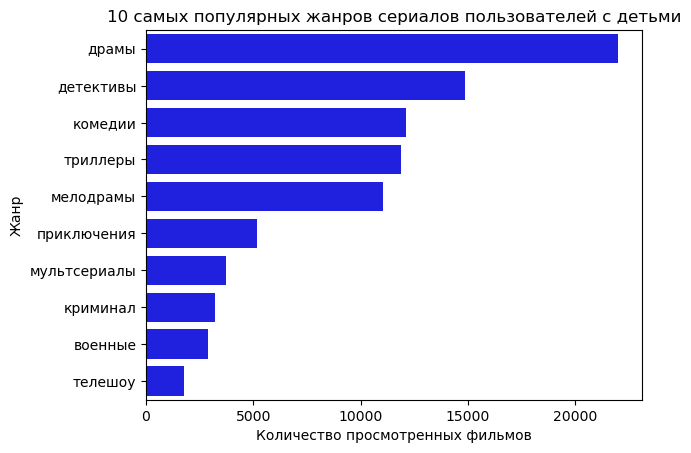

In [49]:
# Подсчет количества просмотренных сериалов для каждого жанра пользователей с детьми
popular_genres_with_kids_series_top_10 = user_actions_with_kids_series_genres_split.genres_split.value_counts().head(10)
# Преобразование результатов в DataFrame
popular_genres_with_kids_series_top_10 = pd.DataFrame(popular_genres_with_kids_series_top_10)

# Создание столбчатой диаграммы для отображения результатов
sns.barplot(x = popular_genres_with_kids_series_top_10.genres_split, y = popular_genres_with_kids_series_top_10.index, color = 'blue')

# Настройка заголовка и меток осей
plt.title('10 самых популярных жанров сериалов пользователей с детьми')
plt.xlabel('Количество просмотренных фильмов')
plt.ylabel('Жанр')


display(popular_genres_with_kids_series_top_10)

# Отображаем график
plt.show()

Как для обычных пользователей, так и для пользователей с детьми 10 самых популярных жанров не отличаются за исключением 10 места 

Самые не популярные жанры сериалов

,genres_split
токшоу,3
о знаменитостях,2
катастрофы,2
реалити,2
вокруг света,2
охота и рыбалка,1
короткометражные,1
для самых маленьких,1
воспитание детей,1
живая природа,1


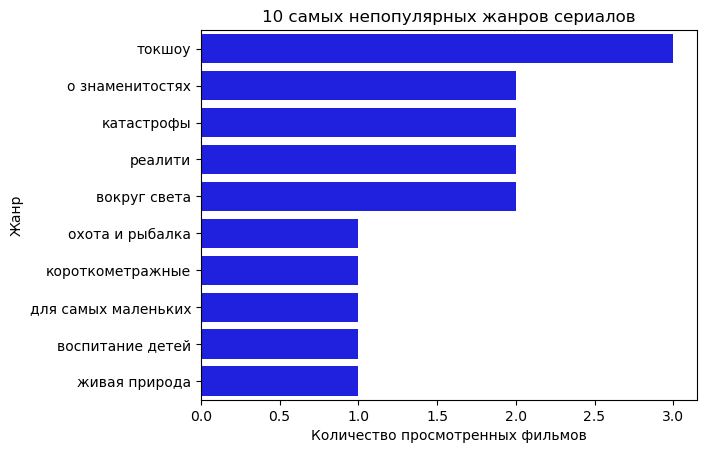

In [50]:
# Анализ наименее популярных жанров сериалов
unpopular_genres_series_top_10 = user_actions_genres_split_series.genres_split.value_counts().tail(10)
# Преобразование результатов в DataFrame
unpopular_genres_series_top_10 = pd.DataFrame(unpopular_genres_series_top_10)

# Создание столбчатой диаграммы для отображения результатов
sns.barplot(x = unpopular_genres_series_top_10.genres_split, y = unpopular_genres_series_top_10.index, color = 'blue')

# Настройка заголовка и меток осей
plt.title('10 самых непопулярных жанров сериалов')
plt.xlabel('Количество просмотренных фильмов')
plt.ylabel('Жанр')


display(unpopular_genres_series_top_10)

# Отображаем график
plt.show()

Самые непопулярные жанры сериалов для пользователей с детьми

,genres_split
реалити,1
детские,1
короткометражные,1
воспитание детей,1
no_genre,1
фильмы,1
анимация,1
медицинские,1
шоу,1
живая природа,1


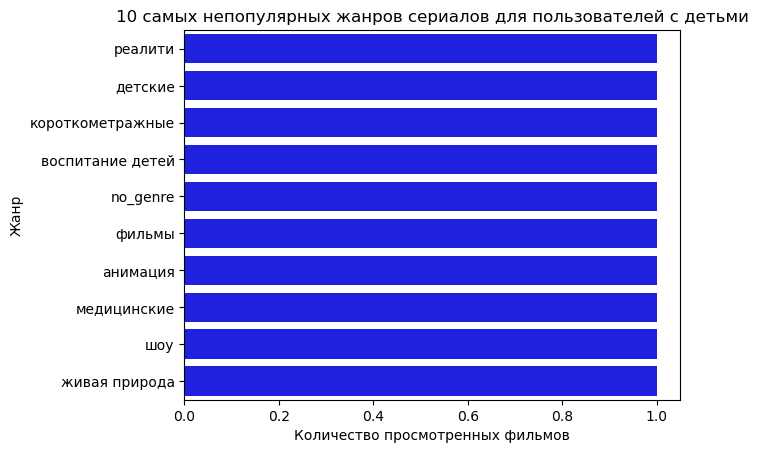

In [51]:
# Анализ наименее популярных жанров сериалов для пользователей с детьми
unpopular_genres_with_kids_series_top_10 = user_actions_with_kids_series_genres_split.genres_split.value_counts().tail(10)
# Преобразование результатов в DataFrame
unpopular_genres_with_kids_series_top_10 = pd.DataFrame(unpopular_genres_with_kids_series_top_10)

# Создание столбчатой диаграммы для отображения результатов
sns.barplot(x = unpopular_genres_with_kids_series_top_10.genres_split, y = unpopular_genres_with_kids_series_top_10.index, color = 'blue')

# Настройка заголовка и меток осей
plt.title('10 самых непопулярных жанров сериалов для пользователей с детьми')
plt.xlabel('Количество просмотренных фильмов')
plt.ylabel('Жанр')


display(unpopular_genres_with_kids_series_top_10)

# Отображаем график
plt.show()

Также как и с фильмами саме непопулярные жанры - довольно специфичные жанры

**Вывод:** Были выявлены 10 самых популярных фильмов и сериалов на последний месяц. Этии данные можно использовать как рекомендации для пользователей, которые их не смотрели для удержания, также их можно использовать в рекламных компаниях для привлечения новых пользователей. Также были выявлены самые популярные жанры как для фильмов, так и для сериалов, на основе этих данных можно подбирать фильмы и сериалы популярных жанров, чтобы добавлять их в библиотеку сервиса. Также был вывод, что предпочтения обычных пользователей и пользователей с детьми практически не отличаются и у пользователей с детьми нет в приоритете контента для детей, поэтому не стоит  делать на него упор. 